In [94]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import hera_pspec  as hp
from scipy import special

In [148]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(window_len/2)-1):-(int(window_len/2))]

333.33333333333337


<IPython.core.display.Javascript object>


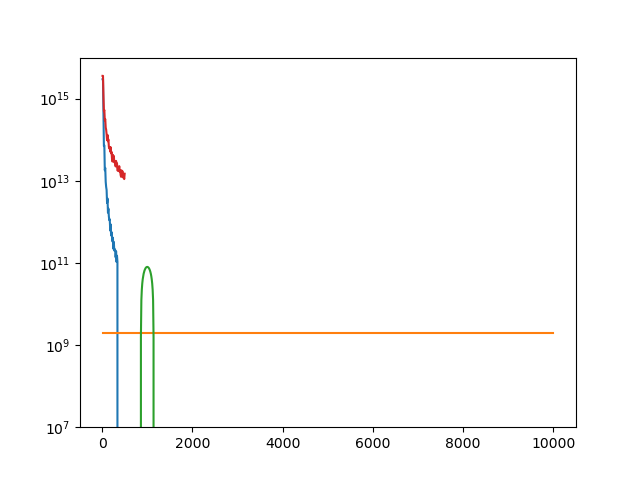

(10000000.0, 1e+16)

In [210]:
B = 100e6 #spectral range of pspec
df = 100e3 # spectral resolution 
D = 14 # dish diameter in meters
L = 2 # wavelength in meters
H1C_z = 18
H1C_bl = 100 # a 2 dish baseline. one of our best bls for H1C
c = 3e8 #speed of light in m/s


H1C_tau = np.arange(np.ceil(B/df))*1/B + 1/B #delay in s
H1C_Pmax=5e15 #[mk^2 h^-3 Mpc^3 ] Delay zero power from Kern et al 2019b
H1C_noise = 2e9 #[mk^2 h^-3 Mpc^3 ] Noise level Kern et al 2019b
H1C_Pwidth = 400 #ns, gaussian foreground FWHM

#H1C_Pk = H1C_Pmax* (1/H1C_tau) + H1C_noise
#H1C_Pk = H1C_Pmax*(1+-(H1C_tau/H1C_Pwidth)**2) # super sharp dropoff is like 2nd order poly/log gaussian
#x = H1C_tau*1e-9/(H1C_bl/c)#/ (D/ L)
#PSF = np.sin(2*np.pi*x) / x
k = 2*np.pi/L 
x = k*D*H1C_tau/(H1C_bl/c)
PSF = (2*special.jve(1,x)/x)**2

print(H1C_bl/c*1e9)
H1C_Pk = np.abs(PSF/PSF.max()) * H1C_Pmax
H1C_Pk[H1C_tau>(H1C_bl/c)] = 0 
H1C_Pk = smooth(H1C_Pk,4)

plt.figure()
plt.semilogy(H1C_tau*1e9, H1C_Pk) #plot the foregrounds

#add noise
H1C_PN = H1C_noise*np.ones_like(H1C_tau)              # noise is flat in Pk
#H1C_Pk = np.max(np.vstack([H1C_Pk,H1C_PN]),axis=0)    # the max between noise and signal. In practice its sum of squares
plt.semilogy(H1C_tau*1e9, H1C_PN)                                                      # but the sum of squares don't work here with the huge negative foreground

# add cable systematic
H1C_sysamp = 8e10 #mK h^-3Mpc^3 amplitude of reflection systematic
H1C_syswidth = 100 #ns, width in delay of systematic (probably similar to sky H1C_Pwidth)
H1C_sysdelay = 1000 #ns, position in delay. Probably related to cable length ~100m*3.33ns/m * .7 * 2? ish yeah
H1C_sys = H1C_sysamp*(1 - (H1C_tau*1e9  - H1C_sysdelay)**2/(2*H1C_syswidth**2))

H1C_Pk = np.max(np.vstack([H1C_Pk,H1C_sys]),axis=0)
plt.semilogy(H1C_tau*1e9, H1C_sys)
H1C_Ptot = np.max(np.vstack([H1C_Pk,H1C_PN,H1C_sys]),axis=0)
#plt.semilogy(H1C_tau*1e9, H1C_Ptot*1.1, 'k')

# H1C_Pscat = smooth(H1C_Ptot,6)
# H1C_Pscat[:2] = H1C_Ptot[:2] #keep the delay 0 power the same
# plt.semilogy(H1C_tau*1e9, H1C_Pscat*1.1, 'k')


# estimate a chromatic beam, higher PSF wings (simulated by sqrt(PSF)) and 50% longer delay 
H1C_Pchrom = np.sqrt(np.abs(PSF/PSF.max())) * H1C_Pmax
#H1C_Pchrom[H1C_tau>(H1C_bl/c*1.5)] = 0 
H1C_Pchrom = smooth(H1C_Pchrom,4)
plt.semilogy(H1C_tau[H1C_tau<(H1C_bl/c*1.5)]*1e9,H1C_Pchrom[H1C_tau<(H1C_bl/c*1.5)])


plt.ylim(1e7,1e16)

In [152]:
cosmo = hp.conversions.Cosmo_Conversions()


<IPython.core.display.Javascript object>


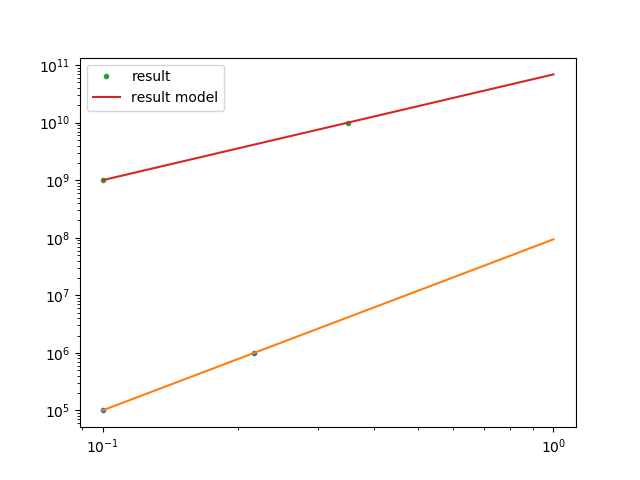

In [211]:
# OVLWA systematics simulation 
d = np.array([[1e5,0.1],[1e6,0.217]]) #from Michaels 0.1% "gain error" simulation
d = np.log10(d)
s = np.polyfit(d[:,1],d[:,0],1)
plt.figure()
plt.loglog(10**d[:,1],10**d[:,0],'.')
O_k = np.linspace(.1,1)
O_Dsys = s[0]*np.log10(O_k)+s[1]
O_Dsys = 10**O_Dsys
plt.loglog(O_k,O_Dsys)

#OVLWA result
d = np.array([[1e9,.1],[1e10,.35]])
d = np.log10(d)
s = np.polyfit(d[:,1],d[:,0],1)
O_D = s[0]*np.log10(O_k)+s[1]
O_D = 10**O_D
plt.loglog(10**d[:,1],10**d[:,0],'.',label='result')
plt.loglog(O_k,O_D,label='result model')
plt.legend()


<IPython.core.display.Javascript object>


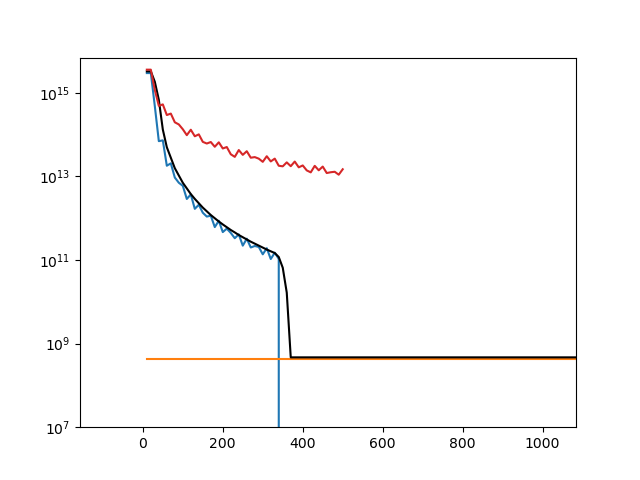

(10000000.0, 1e+16)

In [216]:
#HERA Goal
H4C_z = 18
H4C_bl = 100 # a 2 dish baseline. one of our best bls for H1C
c = 3e8 #speed of light in m/s


H4C_tau = np.arange(np.ceil(B/df))*1/B + 1/B #delay in s
H4C_Pmax=5e15 #[mk^2 h^-3 Mpc^3 ] Delay zero power from Kern et al 2019b
H4C_noise = 2e9 * 71/333 #[mk^2 h^-3 Mpc^3 ] Noise level is 71/333 * Kern et al 2019b
H4C_Pwidth = 400 #ns, gaussian foreground FWHM

#H1C_Pk = H1C_Pmax* (1/H1C_tau) + H1C_noise
#H1C_Pk = H1C_Pmax*(1+-(H1C_tau/H1C_Pwidth)**2) # super sharp dropoff is like 2nd order poly/log gaussian
#x = H1C_tau*1e-9/(H1C_bl/c)#/ (D/ L)
#PSF = np.sin(2*np.pi*x) / x
k = 2*np.pi/L 
x = k*D*H1C_tau/(H1C_bl/c)
PSF = (2*special.jve(1,x)/x)**2

H4C_Pk = np.abs(PSF/PSF.max()) * H1C_Pmax
H4C_Pk[H1C_tau>(H4C_bl/c)] = 0 
H4C_Pk = smooth(H4C_Pk,4)

plt.figure()
plt.semilogy(H4C_tau*1e9, H4C_Pk) #plot the foregrounds

#add noise
H4C_PN = H4C_noise*np.ones_like(H4C_tau)              # noise is flat in Pk
#H1C_Pk = np.max(np.vstack([H1C_Pk,H1C_PN]),axis=0)    # the max between noise and signal. In practice its sum of squares
plt.semilogy(H4C_tau*1e9, H4C_PN)                                                      # but the sum of squares don't work here with the huge negative foreground

# add cable systematic
H4C_sysamp = 8e8 #mK h^-3Mpc^3 amplitude of reflection systematic
H4C_syswidth = 100 #ns, width in delay of systematic (probably similar to sky H1C_Pwidth)
H4C_sysdelay = 2700 #ns, position in delay. Probably related to cable length ~100m*3.33ns/m * .7 * 2? ish yeah
H4C_sys = H4C_sysamp*(1 - (H4C_tau*1e9  - H4C_sysdelay)**2/(2*H4C_syswidth**2))

H4C_Pk = np.max(np.vstack([H4C_Pk,H4C_sys]),axis=0)
plt.semilogy(H1C_tau*1e9, H4C_sys)
H4C_Ptot = np.max(np.vstack([H4C_Pk,H4C_PN,H4C_sys]),axis=0)
#plt.semilogy(H1C_tau*1e9, H1C_Ptot*1.1, 'k')

H4C_Pscat = smooth(H4C_Ptot,6)
H4C_Pscat[:2] = H4C_Ptot[:2] #keep the delay 0 power the same
plt.semilogy(H4C_tau*1e9, H4C_Pscat*1.1, 'k')


# estimate a chromatic beam, higher PSF wings (simulated by sqrt(PSF)) and 50% longer delay 
H4C_Pchrom = np.sqrt(np.abs(PSF/PSF.max())) * H4C_Pmax
#H1C_Pchrom[H1C_tau>(H1C_bl/c*1.5)] = 0 
H4C_Pchrom = smooth(H4C_Pchrom,4)
plt.semilogy(H4C_tau[H4C_tau<(H4C_bl/c*1.5)]*1e9,H4C_Pchrom[H4C_tau<(H4C_bl/c*1.5)])


plt.ylim(1e7,1e16)

In [235]:
print(H1C_tau[0])
H1C_k_parr = H1C_tau * cosmo.tau_to_kpara(H1C_z)
H1C_k = np.sqrt(H1C_k_parr**2 + (cosmo.bl_to_kperp(H1C_z)*bl)**2)
H1C_k3 = H1C_k**3 / (4* np.pi**2)

H4C_k_parr = H4C_tau * cosmo.tau_to_kpara(H4C_z)
H4C_k = np.sqrt(H4C_k_parr**2 + (cosmo.bl_to_kperp(H4C_z)*bl)**2)
H4C_k3 = H4C_k**3 / (4* np.pi**2)


O_k3 = O_k**3 / (4*np.pi**2)
plt.figure()
plt.loglog(H1C_k[H1C_Pk>0],H1C_k3[H1C_Pk>0]*H1C_Pk[H1C_Pk>0],label='HERA Foregrounds')
#plt.loglog(H1C_k,H1C_k3*H1C_PN, label='HERA Y1 Noise')
#plt.loglog(H1C_k,H1C_k3*H1C_sys,label='HERA Y1 Systematic')
plt.loglog(H1C_k,H1C_k3*H1C_Pscat,'--b',label='HERA v1')
plt.loglog(H4C_k,H4C_k3*H4C_Pscat,'-b',label='HERA v2 goal')
plt.loglog(O_k,O_D,'--k',label='OVLWA v1 (Eastwood et al 2019)')
plt.loglog(O_k,O_Dsys,'-k',label='OVLWA v2')


plt.annotate('Foregrounds',[.0135,1e7],[0.05,4e7],arrowprops={'head_length':0.4,'head_width':0.2})
plt.annotate('gain errors',[.105,1e9])

plt.ylabel('$\Delta^2$ [mK$^{2}$]')
plt.xlabel('k [h Mpc$^{-1}$]')
plt.legend()
#plt.loglog(H1C_k,H1C_k3*H1C_Pscat,label='Systematic')

1e-08


<IPython.core.display.Javascript object>

AttributeError: 'FancyArrowPatch' object has no property 'head_length'

In [224]:
plt.annotate?